In [279]:
%pylab inline

import numpy
import pylab

# Open mesh in ply format
def open_ply(filepath):
    f=open(filepath,'r');
    i=0;
    ip=0;
    it=0;
    np=0;
    nt=0;
    for str in f:
        i+=1;
        arr=str.split(" ");
        if(arr[0]=="element" and arr[1]=="vertex"):
            np=int(arr[2]);
            p=numpy.zeros((np,3));
        elif(arr[0]=="element" and arr[1]=="face"):
            nt=int(arr[2]);
            t=numpy.zeros((nt,3));
        elif(i>=11 and i<11+np):
            p[ip,0]=float(arr[0]);
            p[ip,1]=float(arr[1]);
            p[ip,2]=float(arr[2]);
            ip+=1;
        elif(i>=11+np and i<11+np+nt):
            t[it,0]=int(arr[1]);
            t[it,1]=int(arr[2]);
            t[it,2]=int(arr[3]);
            it+=1;
    mesh={};
    mesh["np"]=np;
    mesh["nt"]=nt;
    mesh["p"]=p;
    mesh["t"]=t;
    return mesh;

# Save mesh in ply format
def save_ply(mesh,filepath):
    p=mesh["p"];
    t=mesh["t"];
    np=mesh["np"];
    nt=mesh["nt"];
    f=open(filepath,'w');
    f.write("%i 1\n"%np);
    f.write("ply\n");
    f.write("format ascii 1.0\n");
    f.write("comment ipython ferret, R. Toro 2015\n");
    f.write("element vertex %i\n"%np);
    f.write("property float x\n");
    f.write("property float y\n");
    f.write("property float z\n");
    f.write("element face %i\n"%nt);
    f.write("property list uchar int vertex_indices\n");
    f.write("end_header\n");
    for i in range(0,np):
        f.write("%f %f %f\n"%(p[i,0],p[i,1],p[i,2]));
    for i in range(0,nt):
        f.write("3 %i %i %i\n"%(t[i,0],t[i,1],t[i,2]));
    f.close();

# Save a scalar over vertices to a text file
def saveScalar(s,filename):
    np=len(s);
    f=open(filename,"w");
    f.write("%i 1\n"%np);
    for i in range(0,np):
        f.write("%f\n"%s[i]);
    f.close();

# Area of triangle p0, p1, p2
def A(p0,p1,p2):
    #a,b,c    // side lengths
    #s        // semiperimeter
    a=numpy.linalg.norm(p0-p1);
    b=numpy.linalg.norm(p1-p2);
    c=numpy.linalg.norm(p2-p0);
    s=(a+b+c)/2.0;
    return numpy.sqrt(s*(s-a)*(s-b)*(s-c))

# Normal of triangle a,b,c
def normal(a,b,c):
    v=numpy.cross(b-a,c-a)
    n=v/numpy.linalg.norm(v)
    return n;

# Compute the normals for each vertex in mesh
def normals(mesh):
    np=mesh["np"];
    nt=mesh["nt"];
    p=mesh["p"];
    t=mesh["t"];
    n=numpy.zeros((np,3));
    for i in range(0,nt):
        nn=normal(p[t[i,0]],p[t[i,1]],p[t[i,2]]);
        n[t[i,0]]=numpy.add(n[t[i,0]],nn);
        n[t[i,1]]=numpy.add(n[t[i,1]],nn);
        n[t[i,2]]=numpy.add(n[t[i,2]],nn);
    for i in range(0,np):
        n[i]=n[i]/numpy.linalg.norm(n[i]);
    return n;

# Compute number of neighbours for each vertex in mesh
def neighbours(mesh):
    np=mesh["np"];
    nt=mesh["nt"];
    t=mesh["t"];
    neig=numpy.zeros(np);
    for i in range(0,nt):
        neig[t[i,0]]+=1;
        neig[t[i,1]]+=1;
        neig[t[i,2]]+=1;
    return neig;

# Compute log Jacobian of the deformation of each triangle between two meshes
# with the same topology but different geometry. Distribute the value on
# the vertices
def logJacobian(m1,m2):
    np=m1["np"];
    nt=m1["nt"];
    t=m1["t"];
    p1=m1["p"];
    p2=m2["p"];
    Jmap=numpy.zeros(np);
    neig=neighbours(m1);
    for i in range(0,nt):
        # compute deformation at each triangle
        A1=A(p1[t[i,0]],p1[t[i,1]],p1[t[i,2]]);
        A2=A(p2[t[i,0]],p2[t[i,1]],p2[t[i,2]]);
        if(A1<1e-5):
            continue;
        J=numpy.log(A2/A1);
        # distribute the deformation among the vertices
        Jmap[t[i,0]]+=J;
        Jmap[t[i,1]]+=J;
        Jmap[t[i,2]]+=J;
    for i in range(0,np):
        if(neig[i]>0):
            Jmap[i]/=neig[i];
    return Jmap;

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [250]:
# Adapted from intersect_RayTriangle()
# Copyright 2001, softSurfer (www.softsurfer.com)
# This code may be freely used and modified for any purpose
# providing that this copyright notice is included with it.
# SoftSurfer makes no warranty for this code, and cannot be held
# liable for any real or imagined damage resulting from its use.
# Users of this code must verify correctness for their application.
#    Input:  vector "x", triangle index "it"
#    Output: *c0, *c1 = the triangle-based coordinates of the intersection (when it exists)
#    Return: -1 = triangle is degenerate (a segment or point)
#             0 = disjoint (no intersect)
#             1 = intersect in unique point I1
#             2 = are in the same plane
# code from:http://geometryalgorithms.com/Archive/algorithm_0105/algorithm_0105.htm#intersect_RayTriangle()
def intersect_VectorTriangle(x, i, c, m):
    EPSILON=1e-6;
    np=m["np"];
    nt=m["nt"];
    t=m["t"];
    p=m["p"];
    T=t[i];
    xx=[3];
    
    u=numpy.subtract(p[T[1]],p[T[0]]);
    v=numpy.subtract(p[T[2]],p[T[0]]);
    n=numpy.cross(u,v);
    if(numpy.sqrt(n[0]*n[0]+n[1]*n[1]+n[2]*n[2])<1e-10):
        return -1;

    direc=x;
    w0=-p[T[0]];
    a = numpy.dot(n,w0);
    b = numpy.dot(n,direc);
    if (b>-EPSILON and b<EPSILON):  # ray is parallel to triangle plane
        if (a == 0.0):               # ray lies in triangle plane
            return 2;
        else:
            return 0;              # ray disjoint from plane

    # get intersect point of ray with triangle plane
    r = -a/b;
    # for a segment, also test if (r > 1.0) => no intersect
    if (r < 0.0):                   # ray goes away from triangle
        return 0;                   # => no intersect

    xx=direc*r;    # intersect point of ray and plane

    # is I inside T?
    uu=numpy.dot(u,u);
    uv=numpy.dot(u,v);
    vv=numpy.dot(v,v);
    w=numpy.subtract(xx,p[T[0]]);
    wu=numpy.dot(w,u);
    wv=numpy.dot(w,w);
    D = uv * uv - uu * vv;

    # get and test parametric coords
    ss = (uv * wv - vv * wu) / D;
    if(ss>-EPSILON and ss<EPSILON):
        ss=0;
    if((1-ss)>-EPSILON and (1-ss)<EPSILON):
        ss=1;
    
    tt = (uv * wu - uu * wv) / D;
    if(tt>-EPSILON and tt<EPSILON):
        tt=0;
    if((1-tt)>-EPSILON and (1-tt)<EPSILON):
        tt=1;
    
    c[0]=ss;
    c[1]=tt;
    
    if (ss < 0.0 or tt < 0.0 or (ss + tt) > 1.0):  # I is outside T
        return 0;

    return 1;                      # I is in T

In [271]:
def barycentric(p,mesh):
    # compute barycentric coordinates relative to the topology mesh of the vertices in euclidean space
    # (normally, the vertices in euclidean are in the geometry of mesh)
    
    np_xyz=len(xyz);
    p=mesh["p"];
    t=mesh["t"];
    np=mesh["np"];
    nt=mesh["nt"];
    
    # Interpolate coordinates on reference mesh
    b=numpy.zeros((np_xyz,3));   # the new points in barycentric coordinates are stored in b
    case_deg=0;
    case_disj=0;
    case_parl=0;
    non_mapped=0;
    for i in range(0,np_xyz):
        # look for a triangle in the spherical original mesh containing
        # point i of the target mesh
        
        # display progress
        if(int(i*100/np_xyz)>int((i-1)*100/np_xyz)):
            print("%i%% " % (i*100/np_xyz));
        
        for j in range(0,nt):
            c=[0,0];
            result=intersect_VectorTriangle(xyz[i],j,c,mesh);
            if(result==1):
                b[i]=[j,c[0],c[1]];
                #b[i]=(1-c0-c1)*p[t[j,0]];
                #b[i]=numpy.add(b[i],c[0]*p[t[j,1]]);
                #b[i]=numpy.add(b[i],c[1]*p[t[j,2]]);
                break;
            if(result==-1):
                case_deg+=1;
            if(result==0):
                case_disj+=1;
            if(result==2):
                case_parl+=1;
        
        # if j==nt no triangle was found in the spherical original mesh that contained
        # point i. As an approximation, pick the closest point in the spherical original
        # mesh.
        if(j==nt):
            mindist=numpy.linalg.norm(sub3D(xyz[i],p[0]));
            for k in range(0,np):
                if(numpy.linalg.norm(numpy.subtract(xyz[i],p[k]))<mindist):
                    mindist=numpy.linalg.norm(numpy.subtract(xyz[i],p[k]));
                    imindist=k;
            c=[0,0];
            for k in range(0,nt):
                if(t[k,0]==imindist):
                    break;
                if(t[k,1]==imindist):
                    c=[1,0];
                    break;
                if(t[k,2]==imindist):
                    c=[0,1];
                    break;
            b[i]=[imindist,c[0],c[1]];
            non_mapped+=1;
    if(non_mapped):
        print "WARNING: %i vertices could not be resampled and were mapped to the closest vertex\n" % non_mapped;
    return b;

def euclidean(barycentric,mesh):
    # compute vertices in euclidean coordinates from the barycentric coordinates in barycentric and their
    # reference mesh
    return;

In [272]:
m1=open_ply("/Users/roberto/Desktop/ferret/ferret-sbn/P8-F10/_morph/P8-F10_to_P8-F10.sphere.ply");
m2=open_ply("/Users/roberto/Desktop/ferret/ferret-sbn/P8-F10/_morph/P8-F10_to_P8-F11.sphere.ply");
xyz=m1["p"];
b=barycentric(xyz,m2);

0% 
1% 
2% 
3% 
4% 
5% 
6% 
7% 
8% 
9% 
10% 
11% 
12% 
13% 
14% 
15% 
16% 
17% 
18% 
19% 
20% 
21% 
22% 
23% 
24% 
25% 
26% 
27% 
28% 
29% 
30% 
31% 
32% 
33% 
34% 
35% 
36% 
37% 
38% 
39% 
40% 
41% 
42% 
43% 
44% 
45% 
46% 
47% 
48% 
49% 
50% 
51% 
52% 
53% 
54% 
55% 
56% 
57% 
58% 
59% 
60% 
61% 
62% 
63% 
64% 
65% 
66% 
67% 
68% 
69% 
70% 
71% 
72% 
73% 
74% 
75% 
76% 
77% 
78% 
79% 
80% 
81% 
82% 
83% 
84% 
85% 
86% 
87% 
88% 
89% 
90% 
91% 
92% 
93% 
94% 
95% 
96% 
97% 
98% 
99% 


The algorithm seems to be working but it's extremely slow. I'll use C code instead.
In meshgeometry I could use the function 'resample'. Resample takes 3 inputs:
1. a native mesh m
2. a spherical version of the native mesh m, sm
3. a spherical version of a target (reference) mesh rm.

Surface landmarks over the two spherical meshes are supposed to be in correspondance. The algorithm then resamples the native mesh m to have the topology of the spherical mesh rm: It finds for every vertex in rm the corresponding vertex in sm. In general, the vertex from rm will not map directly to a vertex in sm, but will be inside one of its triangles. The algorithm computes the barycentric coordinates of rm's vertices relative to the triangle in sm that contains it, and reproduces the vertex in the native mesh m by applying the barycentric coordinates to the corresponding native m triangle.

In our case, rm should contain the vertices of the source mesh mapped into a sphere, and m and sm should be the target sphere. For example, rm could be Adult-F03_to_Adult-F03.sphere.py, m = P32-F16_to_P32-F16.ply, and sm=P32-F16_to_P32-F16.sphere.py.

The code for a complete transformation would then be:

mg -i P32-F16.ply -resample P32-F16.sphere.ply Adult-F03.sphere.ply -o P32-F16_as_Adult-F03.ply

In [270]:
# Decompose normal and tangential deformation

# load meshes

#f1="P0-F02";
#f1="P2-F25";
#f1="P4-F06";
f1="P8-F10"

dir="/Users/roberto/Desktop/ferret/ferret-sbn/";
m1=open_ply(dir+f1+"/_morph/"+f1+"_to_"+f1+".ply");
nt=m1["nt"];
np=m1["np"];
t=m1["t"];
p1=m1["p"];

# average deformation field, average jacobian
avrD=numpy.zeros((np,3));
avrJ=numpy.zeros(np);

# compute neighbours
neig=neighbours(m1);

#for f2 in ("P0-F23","P2-F25","P2-F26","P2-F27"):
#for f2 in ("P2-F26","P2-F27","P4-F06","P4-F07","P4-F08","P4-F09"):
#for f2 in ("P4-F07","P4-F08","P4-F09","P8-F10","P8-F11","P8-F13","P8-F14"):
for f2 in ("P8-F11","P8-F13","P8-F14","P16-F12","P16-F15","P16-F21"):
    m2=open_ply(dir+f2+"/_morph/"+f2+"_to_"+f1+".ply");
    p2=m2["p"];
    
    # compute deformation vector field
    d=numpy.zeros((np,3));
    for i in range(0,np):
        d[i]=numpy.subtract(p2[i,],p1[i,]);

    # decompose deformation into normal and tangential
    n=normals(m1); # compute normal direction
    nd=numpy.zeros((np,3));
    td=numpy.zeros((np,3));
    for i in range(0,np):
        nd[i]=n[i]*numpy.dot(d[i],n[i]); # normal deformation
        td[i]=numpy.subtract(d[i],nd[i]);   # tangential deformation

    # smooth the tangential part of the deformation
    td0=numpy.zeros((np,3));
    g=0.99;
    niter=5;
    for j in range(0,niter):
        for i in range(0,nt):
            td0[t[i,0]]=numpy.add(td0[t[i,0]],numpy.add(td[t[i,1]],td[t[i,2]]));
            td0[t[i,1]]=numpy.add(td0[t[i,1]],numpy.add(td[t[i,2]],td[t[i,0]]));
            td0[t[i,2]]=numpy.add(td0[t[i,2]],numpy.add(td[t[i,0]],td[t[i,1]]));
        for i in range(0,np):
            td[i]=numpy.add(g*td[i],(1-g)*td0[i]/(2.0*neig[i]));

    # recompose the deformation with a weighted tangential part, add to average deformation field
    w=0.5;
    for i in range(0,np):
        d[i]=numpy.add(nd[i],td[i]*w);
    avrD=numpy.add(avrD,d);
    
    # replace mesh m2 with m1 + new deformation
    for i in range(0,np):
        p2[i]=numpy.add(p1[i],d[i]);

    # compute jacobian of area deformation, add to average jacobian
    J=logJacobian(m1,m2);
    avrJ=numpy.add(avrJ,J);
    
avrJ=(1/7.0)*avrJ;
avrD=(1/7.0)*avrD;

saveScalar(avrJ,"/Users/roberto/Desktop/avrJ.txt");
for i in range(0,np):
    p2[i]=numpy.add(p1[i],avrD[i]);
save_ply(m2,"/Users/roberto/Desktop/average_P8-F10base.ply");


In [197]:
dir="/Users/roberto/Desktop/ferret/ferret-sbn/";

t=(0,0, 1,1,1, 2,2,2,2, 3,3,3,3, 4,4,4, 5,5,5,5, 6,6,6);
n=(("P0-F02","P0-F23"),
   ("P2-F25","P2-F26","P2-F27"),
   ("P4-F06","P4-F07","P4-F08","P4-F09"),
   ("P8-F10","P8-F11","P8-F13","P8-F14"),
   ("P16-F12","P16-F15","P16-F21"),
   ("P32-F16","P32-F17","P32-F18","P32-F19"),
   ("Adult-F01","Adult-F03","Adult-F04"));
m=[];
for i in range(0,len(n)):
    m.append([]);
    for j in range(0,len(n[i])):
        filename=dir+n[i][j]+"/_morph/"+n[i][j]+"_to_"+n[i][0]+".ply";
        m[i].append(open_ply(filename));


Each brain was transformed into each other based on a series of common landmarks.
In each transformation a_to_b the geometry is that of a and the topology that of b. Then, a_to_a is brain a with its geometry and its native topology. The geometric transformation between a and b can be achieved either over the topology of a or the topology of b. In general, it may be better to use the topology with the denser sampling of the geometry.

In the following problem, I would like to map all vertices of Adult-F03 into the geometry of P02-F02. For this, I will first map the points into the geometry of one P32 brain, then into that of a P16 brain, P8, P4, P2 and finally P02-F02. The choice of the intermediate brains is arbitrary. I will simply choose the first from the list, but later I would like to chose them all, to produce different perspectives on the same projection. The sequence of transformations will be then:

Adult-F03 : P32-F16 : P16-F12 : P8-F10 : P4-F06 : P2-F25 : P0-F02.

For each transformation, the steps are as follows:

1. The original vertices are those of Adult-F03_to_Adult-F03,
2. P32-F16_to_Adult-F03 provides the vertices of Adult-F03 projected onto P32-F16,
3. I obtain triangle coordinates of the vertices in P32-F16_to_Adult-F03 in the topology P32-F16. Each vertex of coordinates x,y,z is mapped into coordinates i,s,t, where i is the index of a triangle in the topology P32-F16 and s,t are barycentric coordinates,
4. I obtain triangle coordinates of the vertices of barycentric coordinates i,s,t in the topology P32-F16 and transform them into barycentric coordinates i,s,t in P16-F12 by using P32-F16_to_P16-F12.

For each a_to_b mesh, there is also a a_to_b.sphere version. In the .sphere version the topology is that of a and the geometry that of b. Not really the geometry (because it's a sphere), but the position of the vertices in the sphere, which is such that they move the landmarks from a to match those of b.

The computation of barycentri coordinates should be easier using the spherical meshes. The steps in that case would be:

1. have vertices Adult-F03.sphere: move them to native space (trivial)
2. Use Adult-F03_to_Adult-F01.sphere to move the vertices of Adult-F03 to Adult-F01
3. have vertices Adult-F01.sphere: move them to native space,
4. Get barycentric coordinates of these vertices relative to the original Adult-F01 sphere topology, that in Adult-F01_to_Adult-F01.sphere,
5. Obtain vertices in P32-F16 by using Adult-F01_to_P32-F16.sphere and the previous barycentric coordinates
6. have vertices P32-F16.sphere: move them to native space,
7. Compute barycentric coordinates relative to the original P32-F16 sphere topology
8. Obtain vertices in P16-F12 by using P32-F16_to_P16-F12 and the previous barycentric coordinates
9. have vertices P16-F12.sphere: move them to native space,
etc.

In [198]:
g_f01=geom("Adult-F03","Adult-F01","Adult-F03_to_Adult-F01");
g_f16=topo(g1,"P32-F16","Adult-F01_to_P32-F16");


[[{'np': 2258, 'nt': 4512, 'p': array([[ 1.049709, -1.543577, -3.904279],
          [ 1.431044, -0.990687, -3.92231 ],
          [ 0.369462, -1.43425 , -3.795803],
          ..., 
          [-3.181885,  0.868488,  3.433966],
          [-1.825432, -1.406168,  3.563831],
          [-1.335176, -1.507696,  3.524995]]), 't': array([[  3.00000000e+00,   7.57000000e+02,   7.54000000e+02],
          [  1.00000000e+00,   7.60000000e+02,   7.55000000e+02],
          [  1.00000000e+00,   7.55000000e+02,   7.56000000e+02],
          ..., 
          [  7.48000000e+02,   2.24200000e+03,   2.25500000e+03],
          [  7.49000000e+02,   2.25700000e+03,   2.25600000e+03],
          [  7.41000000e+02,   2.25000000e+03,   2.25700000e+03]])},
  {'np': 2258,
   'nt': 4512,
   'p': array([[  1.65794200e+00,  -1.41670500e+00,  -3.91746500e+00],
          [  2.14248500e+00,  -9.51966000e-01,  -3.88367300e+00],
          [  9.37912000e-01,  -1.29562800e+00,  -3.91286700e+00],
          ..., 
          [ -3.88

In [202]:
a=[1,2,3];
b=[2,3,4];
print numpy.dot(a,b);

20


# Regression

Running the surface resampling in python was too slow, I moved to meshgeometry. It turned out that all the pipeline could be done using only the 'resample' function in meshgeometry (code sbn_4D.sh). I wrote a script that produced ~6000 surfaces for the different ages, all with the topology of Adult-F01, using all different paths to go from Adult-F01 to the 2 P0 surfaces. Now, for each vertex in Adult-F01 I have a series of positions describing the transition from P0 to Adult.

I want to use a non-linear regression to fit the trajectory of each vertex. I will use an algorithm similar to LOWESS: at each time point I will fit a regression line based on a weighted combination of the neighbouring data. I'll try the algorithm in simulated data first.

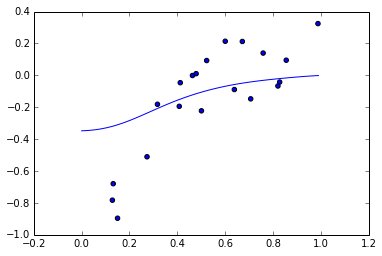

In [363]:
N=20;
x=numpy.random.rand(N);
y=numpy.random.rand(N);
g=0.5;
y=numpy.add((1-g)*y,g*numpy.log(x));
pylab.scatter(x,y);

c=0.9;
N=100;
a=numpy.zeros(N);
b=numpy.zeros(N);
for tt in range(0,N):
    a[tt]=tt/float(N);
    f=0;
    wsum=0;
    for i in range(len(x)):
        w=(1-c) + c/(numpy.power(0.1*(x[i]-a[tt]),2)+0.001);
        f+=y[i]*w;
        wsum+=w;
    b[tt]=f/float(wsum);
pylab.plot(a,b);
        
    